# ROB313 Assignment 2
Name: Yizhi Zhou

Student No.: 1003002396

Date: 2019.02.24

In [2]:
from data_utils import load_dataset
import matplotlib.pyplot as plt
import math
import numpy as np
from sympy.matrices import GramSchmidt
from numpy import dot
import pandas as pd # Only for formatting and plotting
from IPython.display import display
import time

_COLORS = ['#d6616b', '#e6550d', '#fdae6b', '#e7ba52', '#dbdb8d']

In [8]:
class GLM:
    def __init__(self, datasetName):
        '''
        Load dataset mauna_loa
        '''
        self.dataset = datasetName
        if datasetName == 'rosenbrock':
            self.x_train, self.x_valid, self.x_test, self.y_train, self.y_valid, self.y_test =  load_dataset(datasetName, n_train=1000, d=2)
        else:
            self.x_train, self.x_valid, self.x_test, self.y_train, self.y_valid, self.y_test = load_dataset(datasetName)
        self.dimension = np.shape(self.x_test)[1]
        self.num_trainSet = np.shape(self.x_train)[0]
        self.num_validSet = np.shape(self.x_valid)[0]
        self.num_testSet = np.shape(self.x_test)[0]


    def initCrossValidation(self):
        '''
        Combine the training and validation set together for the splitting in cross-validation
        '''
        self.x_all = np.concatenate([self.x_train, self.x_valid])
        self.y_all = np.concatenate([self.y_train, self.y_valid])
        self.index_all = list(range(np.shape(self.x_all)[0]))
        np.random.seed(99)
        np.random.shuffle(self.index_all)

        self.num_validSet = round(np.shape(self.x_all)[0]/5)
        self.num_trainSet = np.shape(self.x_all)[0] - self.num_validSet


    def initTest(self):
        '''
        Combine the training and validation set together as a whole training set for testing
        '''
        self.x_train = np.concatenate([self.x_train, self.x_valid])
        self.y_train = np.concatenate([self.y_train, self.y_valid])
        self.num_trainSet = np.shape(self.x_train)[0]


    def splitCrossValidation(self, foldIndex):
        '''
        Split data into two sets of ratio 4:1 according to the foldIndex
        INPUT: allData: concatenate dataset
        INPUT: foldIndex: from 1 to 5, decides how to partition the dataset (must be from outside the class)
        OUTPUT: train, set: the 4:1 ratio datasets
        '''
        total = len(self.index_all)
        oneFifth = round(total/5)
        if foldIndex in [1, 2, 3, 4]:
            index_train = self.index_all[:oneFifth*(foldIndex-1)] + self.index_all[oneFifth*foldIndex:]
            index_valid = self.index_all[oneFifth*(foldIndex-1) : oneFifth*foldIndex]
        elif foldIndex == 5: # for the last fold, cound backwards so that it has the same number of data as the other folds
            index_train = self.index_all[:(total-oneFifth)]
            index_valid = self.index_all[(total-oneFifth):]
        self.x_train, self.x_valid = self.x_all[index_train], self.x_all[index_valid]
        self.y_train, self.y_valid = self.y_all[index_train], self.y_all[index_valid]


    def setParameters(self, method='basisfunc', model='polynomial', lamb=0, M=100, theta=0.1, degree=2):
        '''
        Set the parameters that requires tuning here as class attributes
        '''
        self.method = method
        self.model = model
        self.lamb = lamb
        self.M = M
        self.theta = theta
        self.degree = degree


    def normalization(self, x_set):
        '''
        Returned a matrix of the input dataset normalized against its mean and stddev
        '''
        mean = x_set.mean(axis=0, keepdims=True)
        stddev = x_set.std(axis=0, keepdims=True)
        return (x_set - mean)/stddev


    def getPrediction(self, x_set, y_set):
        '''
        Pass in the datasets and output the prediction set and rmse
        '''
        tic = time.time()
        if self.method == 'basisfunc':
            method = BasisFunctions(self.x_train, self.model, self.lamb, self.M, self.degree)
            method.getWeight(self.x_train, self.y_train)
            self.w, self.phiMatrix = method.w, method.phiMatrix
            y_predicted = method.getPhiMatrix(x_set).dot(method.w)

        elif self.method == 'kernel':
            method = Kernels(self.M, self.model, self.lamb, self.theta, self.degree)
            method.getAlpha(self.x_train, self.y_train)
            self.alpha, self.K = method.alpha, method.K
            y_predicted = method.getGram(self.x_train, x_set).T.dot(method.alpha)

        rmse = np.sqrt(pow(np.array(y_predicted-y_set), 2).mean())
        print('With primal approach, the time taken is', time.time()-tic, 'seconds.')

        return y_predicted, rmse


    def runRegression(self, set, graph='on'):
        '''
        Show and return the prediction results
        INPUT: set: can be one of 'cross-validation', 'validation', 'test', or 'train'
        '''
        if set == 'cross-validation':
            X, Y_actual, Y_predicted, RMSE = np.array([[None]]), np.array([[None]]), np.array([[None]]), 0
            self.initCrossValidation()
            for foldIndex in range(1, 6):
                self.splitCrossValidation(foldIndex)
                x, y_actual = self.x_valid, self.y_valid
                X = np.concatenate((X, x))
                Y_actual = np.concatenate((Y_actual, y_actual))
                y_predicted, rmse = self.getPrediction(x, y_actual)
                Y_predicted = np.concatenate((Y_predicted, y_predicted))
                RMSE += rmse/5.
            markersize = 2
        elif set == 'validation':
            X, Y_actual = self.x_valid, self.y_valid
            Y_predicted, RMSE = self.getPrediction(X, Y_actual)
            markersize = 20
        elif set == 'test':
            self.initTest()
            X, Y_actual = self.x_test, self.y_test
            Y_predicted, RMSE = self.getPrediction(X, Y_actual)
            markersize = 20
        elif set == 'train':
            X, Y_actual = self.x_train, self.y_train
            Y_predicted, RMSE = self.getPrediction(X, Y_actual)
            markersize = 2

        if graph == 'on':
            plt.style.use('bmh')
            plt.scatter(X[:, 0], Y_actual[:, 0], s=markersize, color=_COLORS[2])
            plt.scatter(X[:, 0], Y_predicted[:, 0], marker = '*', s=markersize, color=_COLORS[0])
            plt.legend(('Actual', 'Prediction'))
            # plt.plot(X[:, 0], Y_predicted[:, 0], linewidth=1, color=_COLORS[0])
            plt.title('GLM on the %s set of "%s" with %s\n Resulting rmse = %1.4f at lambda = %f' %(set, self.dataset, self.method, RMSE, self.lamb), loc='center', size=12)
            plt.show()
        return RMSE


    def runClassification(self, set):
        '''
        Show and return the prediction results
        INPUT: set: can be one of 'cross-validation', 'validation', 'test', or 'train'
        '''
        if set == 'cross-validation':
            X, Y_actual, Y_predicted, RMSE = np.array([[None]]), np.array([[None]]), np.array([[None]]), 0
            self.initCrossValidation()
            for foldIndex in range(1, 6):
                self.splitCrossValidation(foldIndex)
                x, y_actual = self.x_valid, self.y_valid
                X = np.concatenate((X, x))
                Y_actual = np.concatenate((Y_actual, y_actual))
                y_predicted, rmse = self.getPrediction(x, y_actual)
                Y_predicted = np.concatenate((Y_predicted, y_predicted))
                RMSE += rmse/5.
            markersize = 2
        elif set == 'validation':
            X, Y_actual = self.x_valid, self.y_valid
            Y_predicted, RMSE = self.getPrediction(X, Y_actual)
            markersize = 20
        elif set == 'test':
            X, Y_actual = self.x_test, self.y_test
            Y_predicted, RMSE = self.getPrediction(X, Y_actual)
            markersize = 20
        elif set == 'train':
            X, Y_actual = self.x_train, self.y_train
            Y_predicted, RMSE = self.getPrediction(X, Y_actual)
            markersize = 2

        class_predicted = []
        num_classes = np.shape(self.y_test)[1]
        for y in Y_predicted:
            maxClass = list(y).index(max(y))
            class_base = np.zeros(num_classes)
            class_base[maxClass] = 1
            class_predicted.append(class_base)

        # plt.style.use('bmh')
        # plt.scatter(X[:, 0], Y_actual[:, 0], s=markersize, color=_COLORS[2])
        # plt.scatter(X[:, 0], Y_predicted[:, 0], marker = '*', s=markersize, color=_COLORS[0])
        # plt.legend(('Actual', 'Prediction'))
        # plt.show()

        accuracies = [sum(list(class_predicted)[i]!=list(Y_actual)[i])/2 for i in range(np.shape(class_predicted)[0])]
        accuracy = 1-sum(accuracies)/len(accuracies)
        # print('Accuracy is', str(accuracy*100)+'% for data', self.dataset, 'on the', set, 'set.')
        return accuracy

With primal approach, the time taken is 0.022696256637573242 seconds.
With primal approach, the time taken is 0.025085926055908203 seconds.


0.044230208826182

In [4]:
class BasisFunctions:
    def __init__(self, x_train, model='gaussian', lamb=0, M=3, degree=4):
        self.x_train = x_train
        self.model = model
        self.lamb = lamb
        self.M = M
        self.degree = degree

    def getPhi(self, x, set):
        '''
        Returns a row vector [phi_0(x) phi_1(x) ... phi_{M-1}(x)]
        INPUT x: a column vector of length = self.dimension. In this case of mauna_loa, just a scalar
        INPUT M: dimension of the output row vector
        INPUT: model: basis function models, such as 'polynomial', 'gaussian', 'fourier'
        '''
        row = [1] # phi_0 is always 1
        if self.model == 'gaussian':
            s = (max(self.x_train)-min(self.x_train))/(self.M-2)
            for i in range(1, self.M):
                mu_i = min(self.x_train) + (i-1)*s
                phi_i = math.exp(-pow((x-mu_i), 2)/(2*pow(s, 2)))
                row.append(phi_i)

        if self.model == 'polynomial':
            for i in range(1, self.degree):
                phi_i = pow(x, i)
                row.append(phi_i)

        if self.model == 'DIY':
            period = 0.057
            for d in range(1, self.degree+1):
                row.append(x**d)
            row.append(-math.sin(x*2*math.pi/period))
            row.append(-math.cos(x*2*math.pi/period))
        return row


    def getPhiMatrix(self, set):
        return np.array([self.getPhi(x, set) for x in set])


    def getWeight(self, x_train, y_train):
        '''
        Uses the economic SVD method to compute vector w for f(X, w) = phiMatrix * w
        MUST call getWeightBasisFunc before any testing, since self.w is defined in that function
        OUTPUT: w = V * inverse(ST*S + lamb*I) * ST * UT * y_train
        '''
        self.phiMatrix = self.getPhiMatrix(x_train)
        U, s, VT = np.linalg.svd(self.phiMatrix, full_matrices=False) # The economy SVD (if want full SVD, change the second parameter to True)
        S = np.zeros((U.shape[1], VT.shape[0]))
        S[:VT.shape[0], :VT.shape[0]] = np.diag(s)
        ST, V, UT = S.T, VT.T, U.T
        lambI = np.identity(U.shape[1]) * self.lamb

        w = V.dot(np.linalg.inv(ST.dot(S)+lambI)).dot(ST).dot(UT).dot(y_train)
        self.w = w

## Question 1. Generalized Linear Model with Basis Function

The basis function is constructed with a polynomial of degree 5, and a pair of _sin/cos_ pr the tuned period of traning set, 0.057.

The following cell predicts the model with different regularization factor $\lambda$'s, and finds the optimal regularization factors on both the validation set and test set. A visualization of the test set prediction with the optimal $\lambda$ is then shown.

,lambda,validation,testing
0,0.0000,0.055632,0.044172
1,0.0001,0.055645,0.044174
2,0.0010,0.055764,0.044196
3,0.0500,0.062265,0.045387
4,0.0100,0.056951,0.044413
5,0.0500,0.062265,0.045387
6,0.1000,0.068950,0.046627
7,1.0000,0.178556,0.071051


RMSE is the smallest for validation sets at lambda = 0
RMSE is the smallest for test sets at lambda = 0


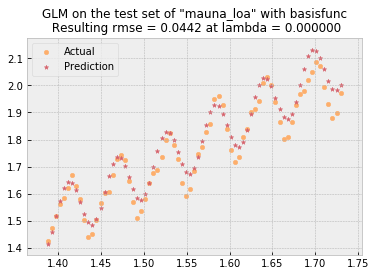

With primal approach, the time taken on the test set is 0.3800981044769287 seconds.


In [5]:
_LAMB = [0, 0.0001, 0.001, 0.05, 0.01, 0.05, 0.1, 1]
LAMB, RMSE, RMSEval = [], [], []
for l in _LAMB:
    glm = GLM('mauna_loa')
    glm.setParameters(method='basisfunc', model='DIY', lamb=l, degree=4)
    RMSEval.append(glm.runRegression('validation', graph = 'off'))
    RMSE.append(glm.runRegression('test', graph = 'off'))
df = pd.DataFrame({'lambda': _LAMB, 'validation': RMSEval, 'testing': RMSE})
display(df)
with open('Table_Q1.tex','w') as tf:
    tf.write(df.to_latex())
print('RMSE is the smallest for validation sets at lambda =', _LAMB[RMSEval.index(min(RMSEval))]) 
print('RMSE is the smallest for test sets at lambda =', _LAMB[RMSE.index(min(RMSE))]) 

glm = GLM('mauna_loa')
glm.setParameters(method='basisfunc', model='DIY', lamb=_LAMB[RMSE.index(min(RMSE))], degree=4)
glm.runRegression('test', graph = 'on')

In [14]:
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.linalg import cho_factor, cho_solve

class Kernels:
    def __init__(self, M=3, model='gaussian', lamb=0, theta=0.1, degree=2):
        self.M = M
        self.model = model
        self.lamb = lamb
        self.theta = theta # only if gaussian kernel is used
        self.degree = degree # only if polynomial kernel is used


    def getGram_Gaussian(self, set1, set2):
        '''
        Calculates the Gram matrix constructed by gaussian kernel k(x,z) = exp(-abs(x-z)^2/theta)
        INPUT: set1 and set2 are N-by-D and N'-by-D matrices
        '''
        # K = np.exp(-np.square(set1-np.transpose(set2))/self.theta) # For D=1
        # pairwise_dists = squareform(pdist(set1, 'euclidean'))
        pairwise_dists = cdist(set1, set2)
        K = np.exp(-pairwise_dists**2 / self.theta)
        return K


    def getGram_Linear(self, set1, set2):
        '''
        Calculates the Gram matrix constructed by linear kernel k(x,z) = x.T * z
        INPUT: set1 and se2 are N-by-D and N'-by-D matrices
        '''
        K = set1.dot(set2.T)
        return K


    def getGram_Polynomial(self, set1, set2):
        '''
        Calculates the Gram matrix constructed by linear kernel k(x,z) = (x.T * z + 1)^d
        INPUT: set1 and set2 are N-by-D and N'-by-D matrices
        '''
        N, M = set1.shape[0], set2.shape[0]
        base = set1.dot(set2.T) + 1 #np.ones((N, M))
        K = np.power(base, self.degree)
        return K


    def getGram_Sinusoid(self, set1, set2):
        '''
        Calculates the Gram matrix constructed by gaussian kernel k(x,z) = cos(wx)*cos(wz) + sin(wx)*sin(wz) = cos(w(x-z))
        INPUT: set1 and set2 are N-by-D and N'-by-D matrices
        '''
        period = 0.057
        K = np.cos((set1-set2.T)*2*math.pi/period)
        return K


    def getGram_DIY(self, set1, set2):
        '''
        Combines polynomial kernel and sinusoidal kernel, to translate the DIY basis function
        INPUT: set1 and set2 are N-by-D and N'-by-D matrices
        '''
        return self.getGram_Polynomial(set1, set2) + self.getGram_Sinusoid(set1, set2)


    def getGram(self, set1, set2):
        if self.model == 'gaussian':
            K = self.getGram_Gaussian(set1, set2)
        elif self.model == 'polynomial':
            K = self.getGram_Polynomial(set1, set2)
        elif self.model == 'DIY':
            K = self.getGram_DIY(set1, set2)
        # print('Gram Matrix:\n', K)
        return K


    def getAlpha(self, x_train, y_train):
        '''
        Uses the Cholesky factorization method to compute matrix alpha for f(X, w) = K * alpha
        MUST call getGram before any testing, since self.K is defined in that function
        OUTPUT: alpha = inverse(K + lamb*I) * y_train
        '''
        self.K = self.getGram(x_train, x_train)
        try:
            R = cho_factor(self.K + np.identity(self.K.shape[0]) * self.lamb)
        except np.linalg.linalg.LinAlgError:
            print('\nNot Positive Definite! Eigenvalues:\n', np.linalg.eigh(self.K)[0])
        # alpha = np.linalg.inv(R).dot(R.T).dot(self.K.T).dot(y_train)
        alpha = cho_solve(R, y_train)
        # print(alpha)
        self.alpha = alpha


    def kernelVisualization(self):
        '''
        Plot k(0, z) and k(1, z+1) where z ranges from -0.1 to 0.1
        '''
        Z = np.array([[z/1000] for z in range(-100, 101)])
        K0 = self.getGram(np.array([0]), Z)
        K1 = self.getGram(np.array([1]), (Z+1))

        plt.style.use('bmh')
        plt.plot(Z[:, 0], K0.T, linewidth=1, color=_COLORS[0])
        plt.scatter(Z[:, 0], K1.T, linewidth=1, color=_COLORS[2])
        plt.legend(('k(0, z)', 'k(1, z+1)'))
        plt.title('Kernel Visualization -- %s'%(self.model), loc='center', size=12)
        plt.show()

## Question 2. Generalized Linear Model with Kernels

The basis function used in the previous question is kernelized as a summation of:
- a polynomial kernel at degree 4, and,
- a sinusoidal kernel using trig identity $cos(X-Y) = sinXsinY + cosXcosY$

The following cells visualizes the kernel using $k(0, z)$ and $k(1, z+1)$ with $z \in [-0.1, 0.1]$, and then chooses a lambda and in the same way as Question 1 and visualizes test result. 

,lambda,validation,testing
0,1.000000e-10,0.055682,0.044191
1,1.000000e-08,0.055633,0.044172
2,1.000000e-06,0.055632,0.044172
3,1.000000e-04,0.055636,0.044172
4,1.000000e-02,0.056005,0.044230
5,1.000000e+00,0.092373,0.050248


RMSE is the smallest for validation sets at lambda = 1e-06
RMSE is the smallest for test sets at lambda = 1e-06


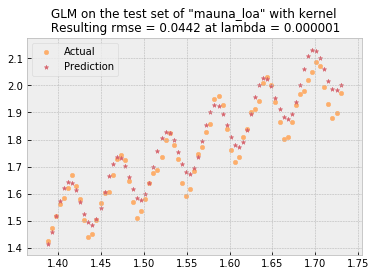

With primal approach, the time taken on the test set is 0.22901201248168945 seconds.


In [7]:
_LAMB = [1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1]
RMSE, RMSEval = [], []
for lamb in _LAMB:
    glm = GLM('mauna_loa')
    glm.setParameters(method='kernel', model='DIY', lamb=lamb, degree=4)
    RMSEval.append(glm.runRegression('validation', graph = 'off'))
    RMSE.append(glm.runRegression('test', graph = 'off'))
df = pd.DataFrame({'lambda': _LAMB, 'validation': RMSEval, 'testing': RMSE})
display(df)
with open('Table_Q2.tex','w') as tf:
    tf.write(df.to_latex())
print('RMSE is the smallest for validation sets at lambda =', _LAMB[RMSEval.index(min(RMSEval))]) 
print('RMSE is the smallest for test sets at lambda =', _LAMB[RMSE.index(min(RMSE))]) 

glm = GLM('mauna_loa')
glm.setParameters(method='kernel', model='DIY', lamb=_LAMB[RMSE.index(min(RMSE))], degree=4)
glm.runRegression('test', graph = 'on')

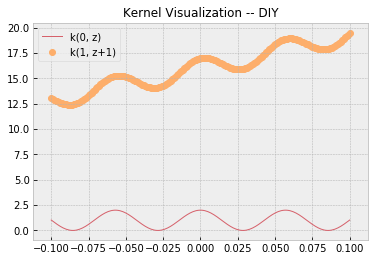

In [37]:
kernel = Kernels(model='DIY', degree=4)
kernel.kernelVisualization()

## Question 3. Generalized Linear Model with Gaussian RBF

A Gaissian kernel implemented with Cholesky factorization is used to predict two regression datasets, _maunaloa_ and _rosenbrock_, and a classification set, _iris_. For each dataset, optimal hyperparameters are chosen from lengthscales $\theta = \{0.05, 0.1, 0.5, 1, 2\}$ and regularization parameters $\lambda = \{0.001, 0.01, 0.1, 1\}$ based on their performance on the validation sets.

In [7]:
_THETA = [0.05, 0.1, 0.5, 1, 2]
_LAMB = [0.001, 0.01, 0.1, 1]
_DATASET = [('mauna_loa', 'regression'), ('rosenbrock', 'regression'), ('iris', 'classification')]
# _THETA = [0.05]
# _LAMB = [0.001]
# _DATASET = [('mauna_loa', 'regression'), ('rosenbrock', 'regression'), ('iris', 'classification')]

RMSE = {}
for (dataset, task) in _DATASET:
    print('Processing dataset', dataset, '...')
    RMSE[dataset] = {'lambda/theta': _LAMB}
    glm = GLM(dataset)
    for theta in _THETA:
        RMSE[dataset][theta] = []
        for lamb in _LAMB:
            glm.setParameters(method='kernel', model='gaussian', lamb=lamb, theta=theta)
            if task == 'regression':
                RMSE[dataset][theta].append(glm.runRegression('validation', graph = 'off'))
            elif task == 'classification':
                RMSE[dataset][theta].append(glm.runClassification('validation'))
RMSE_mauna_loa, RMSE_rosenbrock, RMSE_iris = pd.DataFrame(RMSE['mauna_loa']), pd.DataFrame(RMSE['rosenbrock']), pd.DataFrame(RMSE['iris'])

Processing dataset mauna_loa ...
Processing dataset rosenbrock ...
Processing dataset iris ...


In [8]:
print('Mauna_loa:')
display(RMSE_mauna_loa)
print('Rosenbrock:')
display(RMSE_rosenbrock)
print('Iris:')
display(RMSE_iris)
with open('Table_Q3.tex','w') as tf:
    tf.write(RMSE_mauna_loa.to_latex())
    tf.write(RMSE_rosenbrock.to_latex())
    tf.write(RMSE_iris.to_latex())

Mauna_loa:


,lambda/theta,0.05,0.1,0.5,1,2
0,0.001,1.219709,1.416286,0.347101,0.124479,0.201705
1,0.010,1.117309,1.059137,0.427720,0.229495,0.252404
2,0.100,1.082018,0.965908,0.473741,0.339112,0.217145
3,1.000,1.092211,0.996726,0.606334,0.443615,0.249220


Rosenbrock:


,lambda/theta,0.05,0.1,0.5,1,2
0,0.001,0.735463,0.626585,0.351507,0.257236,0.193240
1,0.010,0.738913,0.632028,0.381007,0.297407,0.241027
2,0.100,0.752307,0.647735,0.419093,0.358185,0.311707
3,1.000,0.808103,0.720521,0.513313,0.466635,0.436547


Iris:


,lambda/theta,0.05,0.1,0.5,1,2
0,0.001,0.806452,0.838710,0.838710,0.838710,0.838710
1,0.010,0.806452,0.838710,0.838710,0.838710,0.806452
2,0.100,0.806452,0.806452,0.838710,0.838710,0.838710
3,1.000,0.806452,0.806452,0.870968,0.870968,0.870968


Mauna_loa with lambda = 0.01 and theta = 1:


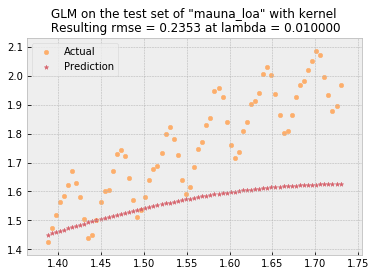

Rosenbrock with lambda = 0.01 and theta = 2:


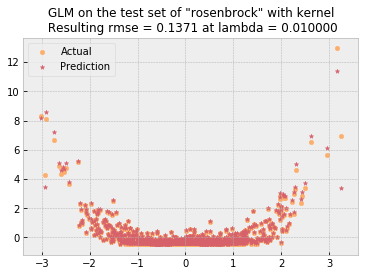

Iris with lambda = 1 and theta = 0.05:

Accuracy is 100.0 % for dataset Iris


In [20]:
print('Mauna_loa with lambda = 0.01 and theta = 1:')
test = GLM('mauna_loa')
test.setParameters(method='kernel', model='gaussian', lamb=0.01, theta=1)
test.runRegression('test')

print('Rosenbrock with lambda = 0.01 and theta = 2:')
test = GLM('rosenbrock')
test.setParameters(method='kernel', model='gaussian', lamb=0.01, theta=2)
test.runRegression('test')

print('Iris with lambda = 1 and theta = 0.05:\n')
test = GLM('iris')
test.setParameters(method='kernel', model='gaussian', lamb=1, theta=0.05)
print('Accuracy is', test.runClassification('test')*100, '% for dataset Iris')